<a href="https://colab.research.google.com/github/nowei/adversarial-dl/blob/master/projected_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# ResNet

*Author: Pytorch Team*

**Deep residual networks pre-trained on ImageNet**

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>

In [98]:
import torch
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet152', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.4.2


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

In [0]:
# !wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
    classes = eval(f.read())

In [0]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://pbs.twimg.com/media/DzIyOyEWwAAOxWv.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

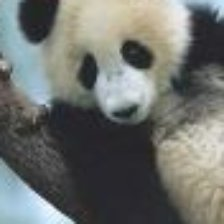

In [4]:
from IPython.display import Image as imshow
imshow(filename)


In [0]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import torch
device = 'cuda'

In [0]:

input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
data = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [6]:


def fgsm_attack(image, epsilon, data_graph):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    print('changed', torch.sum(epsilon*sign_data_grad))
    return perturbed_image

epsilon = 20/255
target = torch.zeros(1,dtype=torch.long)
target[0] = 1
device = 'cuda'
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    data = data.to(device)
    model.to(device)
    # Send the data and label to the device
    target = target.to(device)

    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True
    
    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    print(classes[init_pred.item()], torch.nn.functional.softmax(output[0], dim=0).max())
    # Calculate the loss
    loss = F.nll_loss(output, target)
    
    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    # Re-classify the perturbed image
    output = model(perturbed_data)
    print('perturbedddddd')
# with torch.no_grad():
    # output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probs = torch.nn.functional.softmax(output[0], dim=0)

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca tensor(0.8202, device='cuda:0', grad_fn=<MaxBackward1>)
changed tensor(30.9020, device='cuda:0')
perturbedddddd


In [0]:
trans = transforms.ToPILImage()

In [0]:
preprocess_2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
preprocess_3 = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                   
])

In [10]:
label = torch.tensor([388]).to(data.device)
print(classes[label.item()])
target = torch.tensor([368]).to(data.device)
# target = None
if target:
    print(classes[target.item()])
adv = proj_grad_desc(data, label, model, 0.01, 4 * 1/255, steps=50, target=target)
print('nani')
# curr = preprocess_3(preprocess_2(input_image) + (data - adv).to('cpu'))
# print(curr)
# print(classes[model(curr.to(data.device)).argmax().item()])
# trans(curr[0].to('cpu')).save('nani.jpg')
trans(input_tensor.to('cpu')).save('nanie.jpg')
result = model(adv)
probs = torch.nn.functional.softmax(result[0], dim=0)
adv[:, 0, :, :] = adv[:, 0, :, :] * 0.229 + 0.485
adv[:, 1, :, :] = adv[:, 1, :, :] * 0.224 + 0.456
adv[:, 2, :, :] = adv[:, 2, :, :] * 0.225 + 0.406
print(classes[probs.argmax().item()], probs.max())
trans(adv.to('cpu')[0]).save('pgd_doggo.jpg')
adv[:, 0, :, :] = (adv[:, 0, :, :] - 0.485) / 0.229
adv[:, 1, :, :] = (adv[:, 1, :, :] - 0.456) / 0.224 
adv[:, 2, :, :] = (adv[:, 2, :, :] - 0.406) / 0.225
# trans(adv.to('cpu')[0]).save('pgd_doggo.jpg')
print(adv)
result = model(adv)
probs = torch.nn.functional.softmax(result[0], dim=0)
print(classes[probs.argmax().item()], probs.max())


giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
gibbon, Hylobates lar
nani
gibbon, Hylobates lar tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([[[[ 0.5433,  0.4319,  0.3266,  ..., -1.3362, -1.2875, -1.2602],
          [ 0.5445,  0.4227,  0.2898,  ..., -1.3935, -1.3659, -1.3326],
          [ 0.5455,  0.3826,  0.2622,  ..., -1.4480, -1.4130, -1.4261],
          ...,
          [ 0.7797,  0.7744,  0.7888,  ...,  0.4260,  0.3888,  0.3484],
          [ 0.7985,  0.7926,  0.8081,  ...,  0.4660,  0.4006,  0.3674],
          [ 0.7798,  0.7827,  0.7839,  ...,  0.4869,  0.3985,  0.3527]],

         [[ 1.1115,  0.9765,  0.7526,  ..., -1.0552, -0.9636, -0.9134],
          [ 1.1068,  0.9616,  0.7147,  ..., -1.1121, -1.0396, -1.0086],
          [ 1.0828,  0.9149,  0.6810,  ..., -1.1936, -1.1388, -1.1531],
          ...,
          [ 1.4762,  1.4679,  1.4784,  ...,  0.4270,  0.4380,  0.3813],
          [ 1.4928,  1.4847,  1.5002,  ...,  0.4655,  0.4161,  0.3838],
     

In [81]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      9 ?        00:00:06 node
     24 ?        00:00:11 jupyter-noteboo
    114 ?        00:00:00 tail
    122 ?        00:01:48 python3
   1281 ?        00:00:00 ps


In [8]:
print(classes[probs.argmax().item()])

NameError: ignored

In [0]:
local = trans(perturbed_data.to('cpu')[0])
trans(data.to('cpu')[0]).save('orig_doggo.jpg')
local.save('doggo.jpg')

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
import torch.nn as nn


In [8]:
!nvidia-smi

Mon Nov 25 02:00:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
import os
import h5py
import numpy as np

BASE_PATH = './'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !ls
    !rm homework2.tar

/content
data	   imagenet1000_clsidx_to_labels.txt  pgd_doggo.jpg  tiny_imagenet
doggo.jpg  nanie.jpg			      pt_util.py
dog.jpg    orig_doggo.jpg		      sample_data


In [0]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        # TODO Implement data loading.
        f = h5py.File(h5_file, 'r')
        self.images = f['images'][...]
        self.labels = np.asarray(f['labels'][...], dtype='int64')
        print(self.images.shape)
        f.close()
        self.transform = transform

    def __len__(self):
        # TODO Implement the length function
        return len(self.labels)

    def __getitem__(self, idx):
        # TODO implement the getitem function
        # You should return a tuple of:
        #    a torch tensor containing single image in CxHxW format and
        #    the label as a single tensor scalar.
        data = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        return (data, label)


In [0]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
data_train = H5Dataset(DATA_PATH + 'train.h5', transform=preprocess)
print(len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=preprocess)
print(len(data_test))


(100000, 64, 64, 3)
100000
(8000, 64, 64, 3)
8000


In [100]:
import time
from torch.autograd import Variable
#training
# train = datasets.ImageNet('./data/', train=True, transform=preprocess, download=True)
# train_loader = DataLoader(train, batch_size=128)
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

model_training = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=False)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64,\
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, \
                                          shuffle=False, **kwargs)
model_training.to(device)
model_training.train()
model.eval()
optimizer_robust = optim.SGD(model_training.parameters(), lr=0.01)
# optimizer_normal = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
log_interval = 100
model.to(device)
try:
    model_training.load_state_dict(torch.load('./mytraining.pt'))
except Exception as e:
    print(e)
    print("there weren't any weights")

Using device cuda
num cpus: 2


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.4.2


In [0]:
def proj_grad_desc(x, y, model, step_size=0.01, epsilon=4 * 1/255, steps=50, target=None):
    adversary = x.clone().detach().requires_grad_(True).to(x.device)
    max_diff = x + epsilon
    min_diff = x - epsilon
    for i in range(steps):
        curr = adversary.clone().detach().requires_grad_(True).to(adversary.device)
        output = model(curr)
        loss = loss_fn(output, target.squeeze() if target else y.squeeze())
        loss.backward()
        with torch.no_grad():
            curr_grad = curr.grad * step_size 
            if target:
                adversary -= curr_grad
            else:
                adversary += curr_grad
        adversary = torch.max(torch.min(adversary, max_diff), min_diff)
        # adversary = adversary.clamp(0, 1)
    return adversary.detach()

In [101]:
try:

    for epoch in range(start_epoch, 50):
        model_training.train()
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            x_adv = proj_grad_desc(x, y, model_training, step_size=0.01, epsilon=4 * 1/255)
            optimizer_robust.zero_grad()
            y_pred = model_training(x_adv)
            loss = loss_fn(y_pred, y.squeeze())
            loss.backward()
            optimizer.step()
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            break
        print("epoch {}: loss {}".format(epoch, loss.item()))
        model_training.eval()
        correct_robust = 0
        correct_normal = 0
        test_loss_robust = 0
        test_loss_normal = 0
        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            x_adv_robust = proj_grad_desc(x, y, model_training, step_size=0.01, epsilon=4 * 1/255)
            x_adv_normal = proj_grad_desc(x, y, model, step_size=0.01, epsilon=4 * 1/255)                
            optimizer_robust.zero_grad()
            y_pred_robust = model_training(x_adv_robust)
            y_pred_normal = model(x_adv_normal)
            test_loss_on_robust = F.cross_entropy(y_pred_robust, y.squeeze(), reduction='elementwise_mean')
            test_loss_on_normal = F.cross_entropy(y_pred_normal, y.squeeze(), reduction='elementwise_mean')
            test_loss_robust += test_loss_on_robust
            test_loss_normal += test_loss_on_normal
            pred_robust = y_pred_robust.max(1)[1]
            pred_normal = y_pred_normal.max(1)[1]

            correct_mask = pred_robust.eq(y.view_as(pred_robust))
            num_correct_robust = correct_mask.sum().item()
            correct_robust += num_correct_robust

            correct_mask = pred_normal.eq(y.view_as(pred_normal))
            num_correct_normal = correct_mask.sum().item()
            correct_normal += num_correct_normal

            # if log_interval is not None and batch_idx % log_interval == 0:
            print('{} Test: [{}/{} ({:.0f}%)]\tRobust Loss: {:.6f}\tNormal Loss: {:.6f}'.format(
                time.ctime(time.time()),
                batch_idx * len(x), len(test_loader.dataset),
                100. * batch_idx / len(test_loader), test_loss_on_robust, test_loss_on_normal))
        test_accuracy_robust = 100. * correct_robust / len(test_loader.dataset)
        test_accuracy_normal = 100. * correct_normal / len(test_loader.dataset)
        print("epoch {}: {}% robust accuracy, {}% normal accuracy".format(epoch, test_accuracy_robust*100, test_accuracy_normal * 100))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model_training.save_state_dict('mytraining.pt')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    torch.save(model_training.state_dict(),'./mytraining.pt')


Mon Nov 25 03:45:29 2019 Train Epoch: 0 [0/100000 (0%)]	Loss: 7.105850
epoch 0: loss 7.105849742889404


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Mon Nov 25 03:45:32 2019 Test: [0/8000 (0%)]	Robust Loss: 7.039098	Normal Loss: 34.044773
Mon Nov 25 03:45:34 2019 Test: [64/8000 (1%)]	Robust Loss: 7.006715	Normal Loss: 30.927504
Mon Nov 25 03:45:36 2019 Test: [128/8000 (2%)]	Robust Loss: 7.180508	Normal Loss: 31.821222
Mon Nov 25 03:45:38 2019 Test: [192/8000 (2%)]	Robust Loss: 7.098144	Normal Loss: 33.720978
Mon Nov 25 03:45:41 2019 Test: [256/8000 (3%)]	Robust Loss: 7.158152	Normal Loss: 32.185883
Mon Nov 25 03:45:43 2019 Test: [320/8000 (4%)]	Robust Loss: 7.201855	Normal Loss: 31.958851
Mon Nov 25 03:45:45 2019 Test: [384/8000 (5%)]	Robust Loss: 7.099662	Normal Loss: 29.837330
Mon Nov 25 03:45:47 2019 Test: [448/8000 (6%)]	Robust Loss: 7.087817	Normal Loss: 33.889820
Mon Nov 25 03:45:49 2019 Test: [512/8000 (6%)]	Robust Loss: 7.051002	Normal Loss: 32.976254
Mon Nov 25 03:45:52 2019 Test: [576/8000 (7%)]	Robust Loss: 7.061491	Normal Loss: 36.702423
Mon Nov 25 03:45:54 2019 Test: [640/8000 (8%)]	Robust Loss: 7.183473	Normal Loss: 3

Traceback (most recent call last):
  File "<ipython-input-101-8fb7e2a50819>", line 28, in <module>
    x_adv_robust = proj_grad_desc(x, y, model_training, step_size=0.01, epsilon=4 * 1/255)
  File "<ipython-input-90-3a87b2f1c1a3>", line 7, in proj_grad_desc
    output = model(curr)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 541, in __call__
    result = self.forward(*input, **kwargs)
  File "/root/.cache/torch/hub/pytorch_vision_v0.4.2/torchvision/models/resnet.py", line 203, in forward
    x = self.layer3(x)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 541, in __call__
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py", line 92, in forward
    input = module(input)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 541, in __call__
    result = self.forward(*input, **kwargs)
  File "/root/.cache/torch/hub/pytorch

In [17]:
!nvidia-smi

Mon Nov 25 01:58:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    33W / 250W |  16259MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  